In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from numba import jit

%matplotlib inline

In [2]:
from conditional_bg.models.polymer import polymer_model
from conditional_bg.models.gaussian import gaussian_model
from conditional_bg.likelihood.gaussian_likelihood import gaussian_likelihood
from conditional_boltzmann.transforms.internal_transform_layers import internal_transformation_2D
from conditional_boltzmann.transforms.norm_layers import norm_layer

from conditional_bg.network.coupling_networks import MLP
from conditional_bg.network.conditional_generator import conditional_generator
from conditional_bg.network.dataset import transform_dataset
from conditional_bg.training.train_schedule import schedule_trainer
from conditional_bg.samplers.inertial_langevin import inertial_langevin_integrator


In [3]:

def cv(x):

    x_particle = x.reshape(x.shape[0], 7,2)

    x_centered = x_particle - torch.mean(x_particle, dim=1, keepdims=True)

    r = torch.norm(x_centered, dim=-1)

    msd = torch.square(r).mean(dim=-1)

    return torch.sqrt(msd).unsqueeze(-1)

In [4]:

device = torch.device("cuda:0")

T_ref = 0.1
k = 1000
CV_range = [1, 1.25]

system = polymer_model(n_particles=7, dimensions=2, eps=1, sigma=1, d_bond=1.1224, k_bond=5, theta_angle=np.pi, k_angle=1.4, distance_eps=1e-8)
prior = gaussian_model(1, 11, reference_T=T_ref, device=device)

likelihood = gaussian_likelihood(k)



In [5]:
# Load and shuffle train data

# Load and shuffle train data
stride = 10
train_conf = torch.load("data/train_configurations.pt")[::stride]
train_cond = torch.load("data/train_conditions.pt")[::stride]
train_T = torch.load("data/train_temperatures.pt")[::stride]

In [6]:
angle_shift = np.array([0,0,0,0,0]).astype(np.float32)
transform = internal_transformation_2D(7, torch.from_numpy(angle_shift).cuda(0), device, first_angle_unsigned=True, jacobian_regularization=1e-8)

# Transoform train data to internal coordinates and back for 2 Reasons:
# To center particle 1 and its bond to particle 2 correctly
# TO initialize the normalization layer
with torch.no_grad():

    train_conf = transform.F_zx(transform.F_xz(train_conf)[0])[0]

    internal = transform.F_xz(train_conf)[0]

    indices = torch.where(internal[:, 1] < 0)[0]
    train_conf[indices, 1::2] =  -train_conf[indices, 1::2]

    internal = transform.F_xz(train_conf)[0]
    norm = norm_layer(internal, device)
    
    train_conf = transform.F_zx(internal)[0]

In [7]:
masks = torch.from_numpy(np.array([
                                    [1,0,1,0,1,0,1,0,1,0,1], 
                                    [0,1,0,1,0,1,0,1,0,1,0],
                                    ]).astype(np.float32)).to(device)


network_parameters = {"n_hidden" : 128,
                        "n_layers" : 3,
                        "activation" : torch.nn.Tanh
                        }

coupling_layer_params = { 
                        "A" : {"masks" : masks.clone(),
                                    "transform_network" :  MLP,
                                    "transform_network_parameters" : network_parameters
                              }
                        }


generator = conditional_generator(
                                    system.dofs, prior, system, "A" * 8, 
                                    device, coupling_layer_params, 
                                    transform_layers=[transform, norm], condition_function=cv, 
                                    condition_dim=1, likelihood=likelihood, norm_range_condition=CV_range
                                    ).to(device)


train_dataset = transform_dataset(generator=generator, 
                              data_tensor=train_conf, 
                              data_temperature=train_T, 
                              test_zx_temperature=[0.05, 0.3], 
                              condition_tensor=train_cond, 
                              CV_range=CV_range, 
                              test_fraction=4000/len(train_conf))


train_routine = schedule_trainer(generator, 
                                    train_dataset.train_data_xz[torch.where(train_dataset.train_T_xz == T_ref)[0]], 
                                    train_dataset.train_c_xz[torch.where(train_dataset.train_T_xz == T_ref)[0]], 
                                    prior.sample(50000, T_ref), 
                                    train_dataset.get_single_temp_test_data(T_ref))


4000 test data points for given temperature found.


In [8]:
# Training!

loss_history = train_routine.train_schedule("polymer_protocol.yaml", train_dataset)


 Epochs:	200 
 LR:		1.00e-03  
 Batch Size:	128  
 N_Conditions:	1 
 T:		0.05 - 0.3 
 w_xz/w_zx:	1/0 
 w_angle:	0.00e+00

E:   1/200  |  Train:   xz -16.711  |  Val.:   xz -17.288  zx  3.977e+24  A_zx  0.669  F_xz 0.91  F_zx 0.01  E_xz  5.94e-01  E_zx  2.55e+02
E:   2/200  |  Train:   xz -18.664  |  Val.:   xz -15.898  zx  5.246e+23  A_zx  0.481  F_xz 0.83  F_zx 0.00  E_xz  6.93e-01  E_zx  2.73e+02
E:   3/200  |  Train:   xz -19.064  |  Val.:   xz -17.637  zx  1.068e+27  A_zx  2.377  F_xz 0.96  F_zx 0.02  E_xz  5.23e-01  E_zx  3.89e+02
E:   4/200  |  Train:   xz -19.950  |  Val.:   xz -15.568  zx  2.068e+25  A_zx  0.068  F_xz 0.87  F_zx 0.00  E_xz  7.25e-01  E_zx  2.55e+02
E:   5/200  |  Train:   xz -20.338  |  Val.:   xz -17.985  zx  1.361e+23  A_zx  0.970  F_xz 0.91  F_zx 0.06  E_xz  7.22e-01  E_zx  3.31e+01
E:   6/200  |  Train:   xz -20.515  |  Val.:   xz -17.656  zx  5.160e+19  A_zx  0.240  F_xz 0.88  F_zx 0.02  E_xz  7.25e-01  E_zx  9.86e+01
E:   7/200  |  Train:   xz -20.719  |

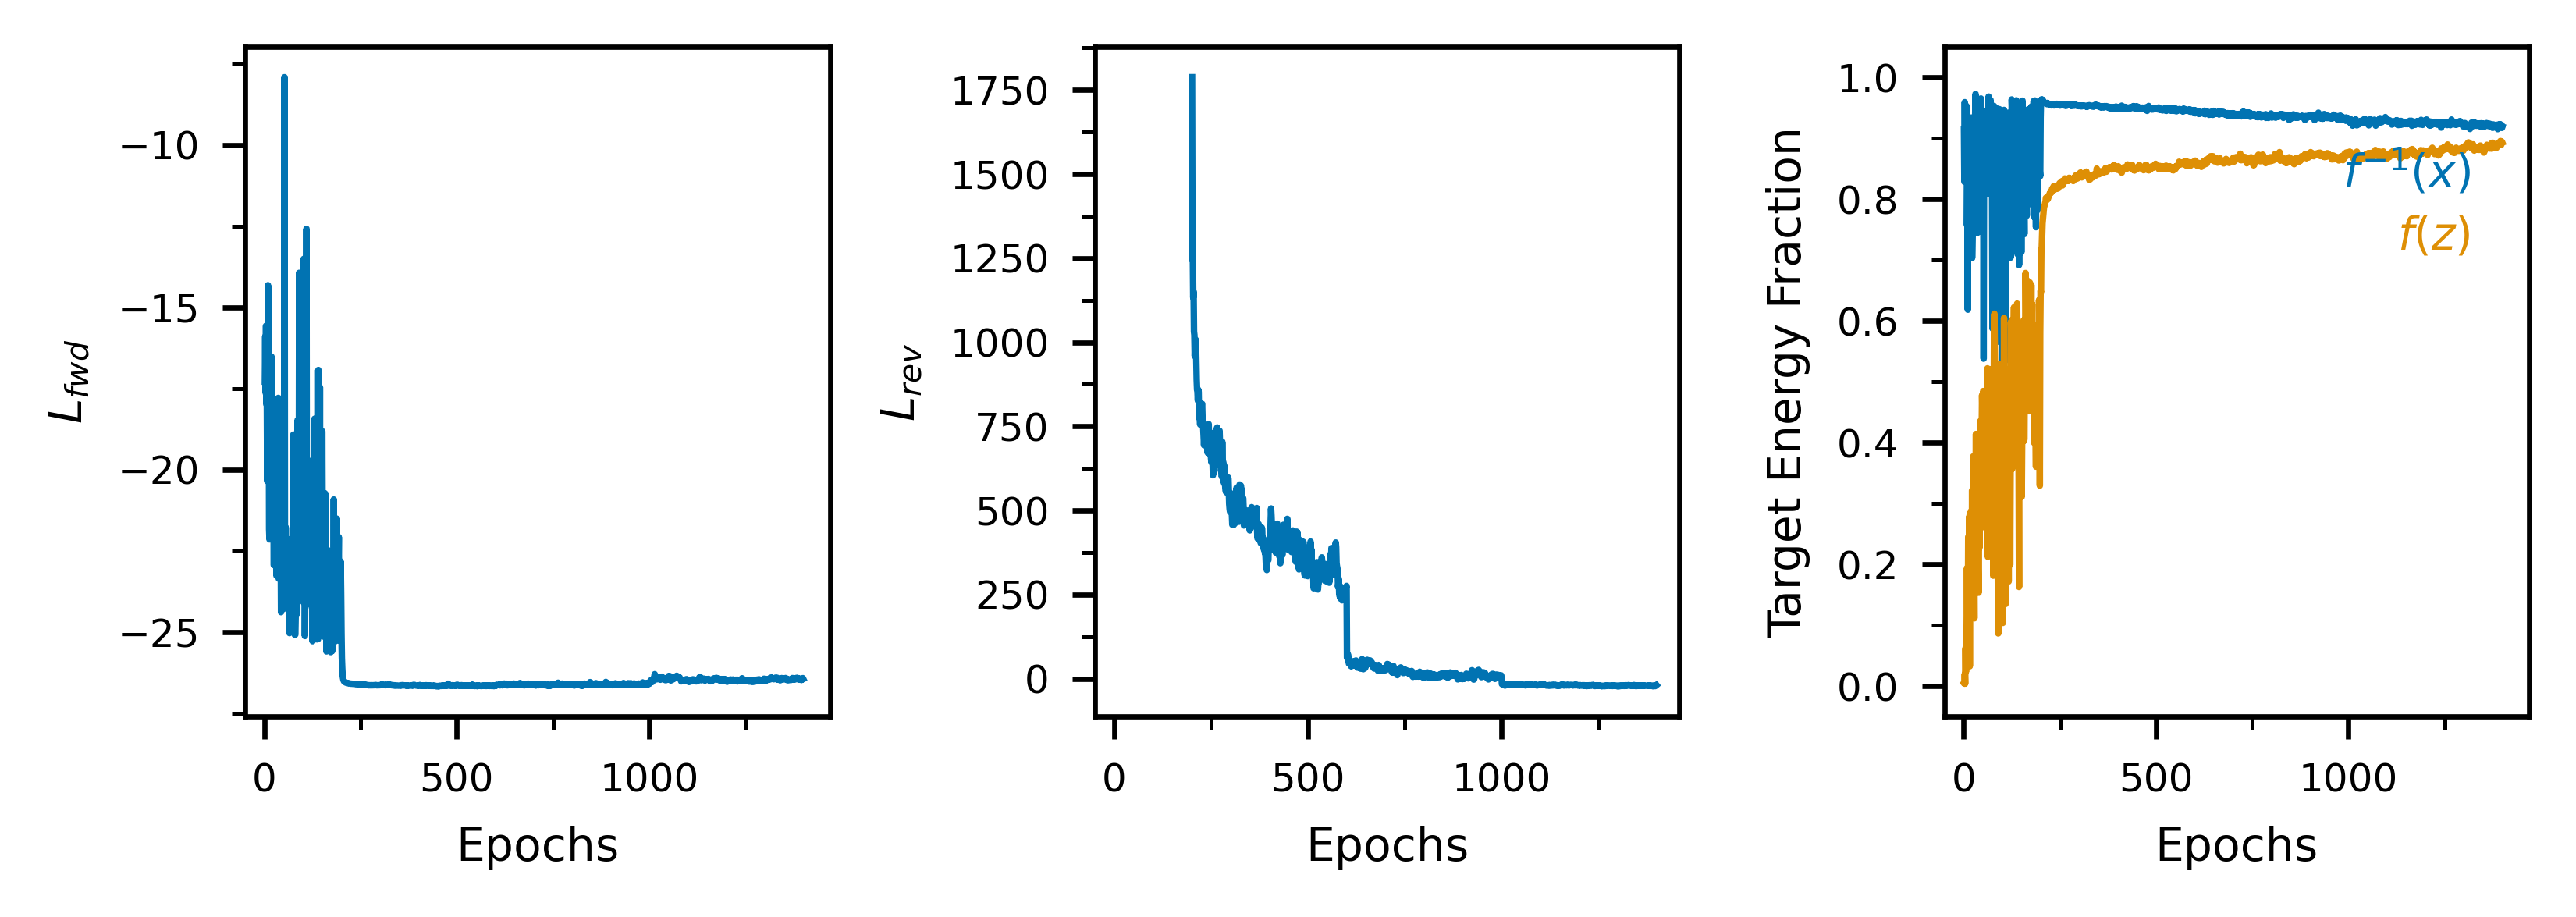

In [9]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
mpl.rcParams.update({'font.size': 7})

fig_size = (14 * 0.393701, 5 * 0.393701)

fig, ax = plt.subplots(1, 3, figsize = fig_size, dpi = 600, sharex=False)

epochs = [loss_history[i][0] for i in range(len(loss_history))]
losses = np.array([loss_history[i][1] for i in range(len(loss_history))])

losses[:200, 1] = np.nan

ax[0].plot(epochs, losses[:, 0], lw = 1)
ax[1].plot(epochs, losses[:, 1], lw = 1)
ax[2].plot(epochs, losses[:, 8], lw = 1)
ax[2].plot(epochs, losses[:, 9], lw = 1)

[ax[i].tick_params(axis='both', which='major', labelsize=6) for i in range(3)] 

ax[2].text(0.9, 0.85, '$f^{-1}(x)$',
        verticalalignment='top', horizontalalignment='right',
        transform=ax[ 2].transAxes, fontsize=7, color="C0")

ax[2].text(0.9, 0.75, '$f(z)$',
        verticalalignment='top', horizontalalignment='right',
        transform=ax[ 2].transAxes, fontsize=7, color="C1") 

ax[2].set_ylim(-0.05, 1.05)
[ax[i].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))for i in range(3)]
[ax[i].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2)) for i in range(3)]

ax[0].set_xlim(-50, None)
ax[1].set_xlim(-50, None)
ax[2].set_xlim(-50, None)

[ax[i].set_xlabel("Epochs") for i in range(3)]
ax[0].set_ylabel("$L_{fwd}$") 
ax[1].set_ylabel("$L_{rev}$") 
ax[2].set_ylabel("Target Energy Fraction")

plt.tight_layout()

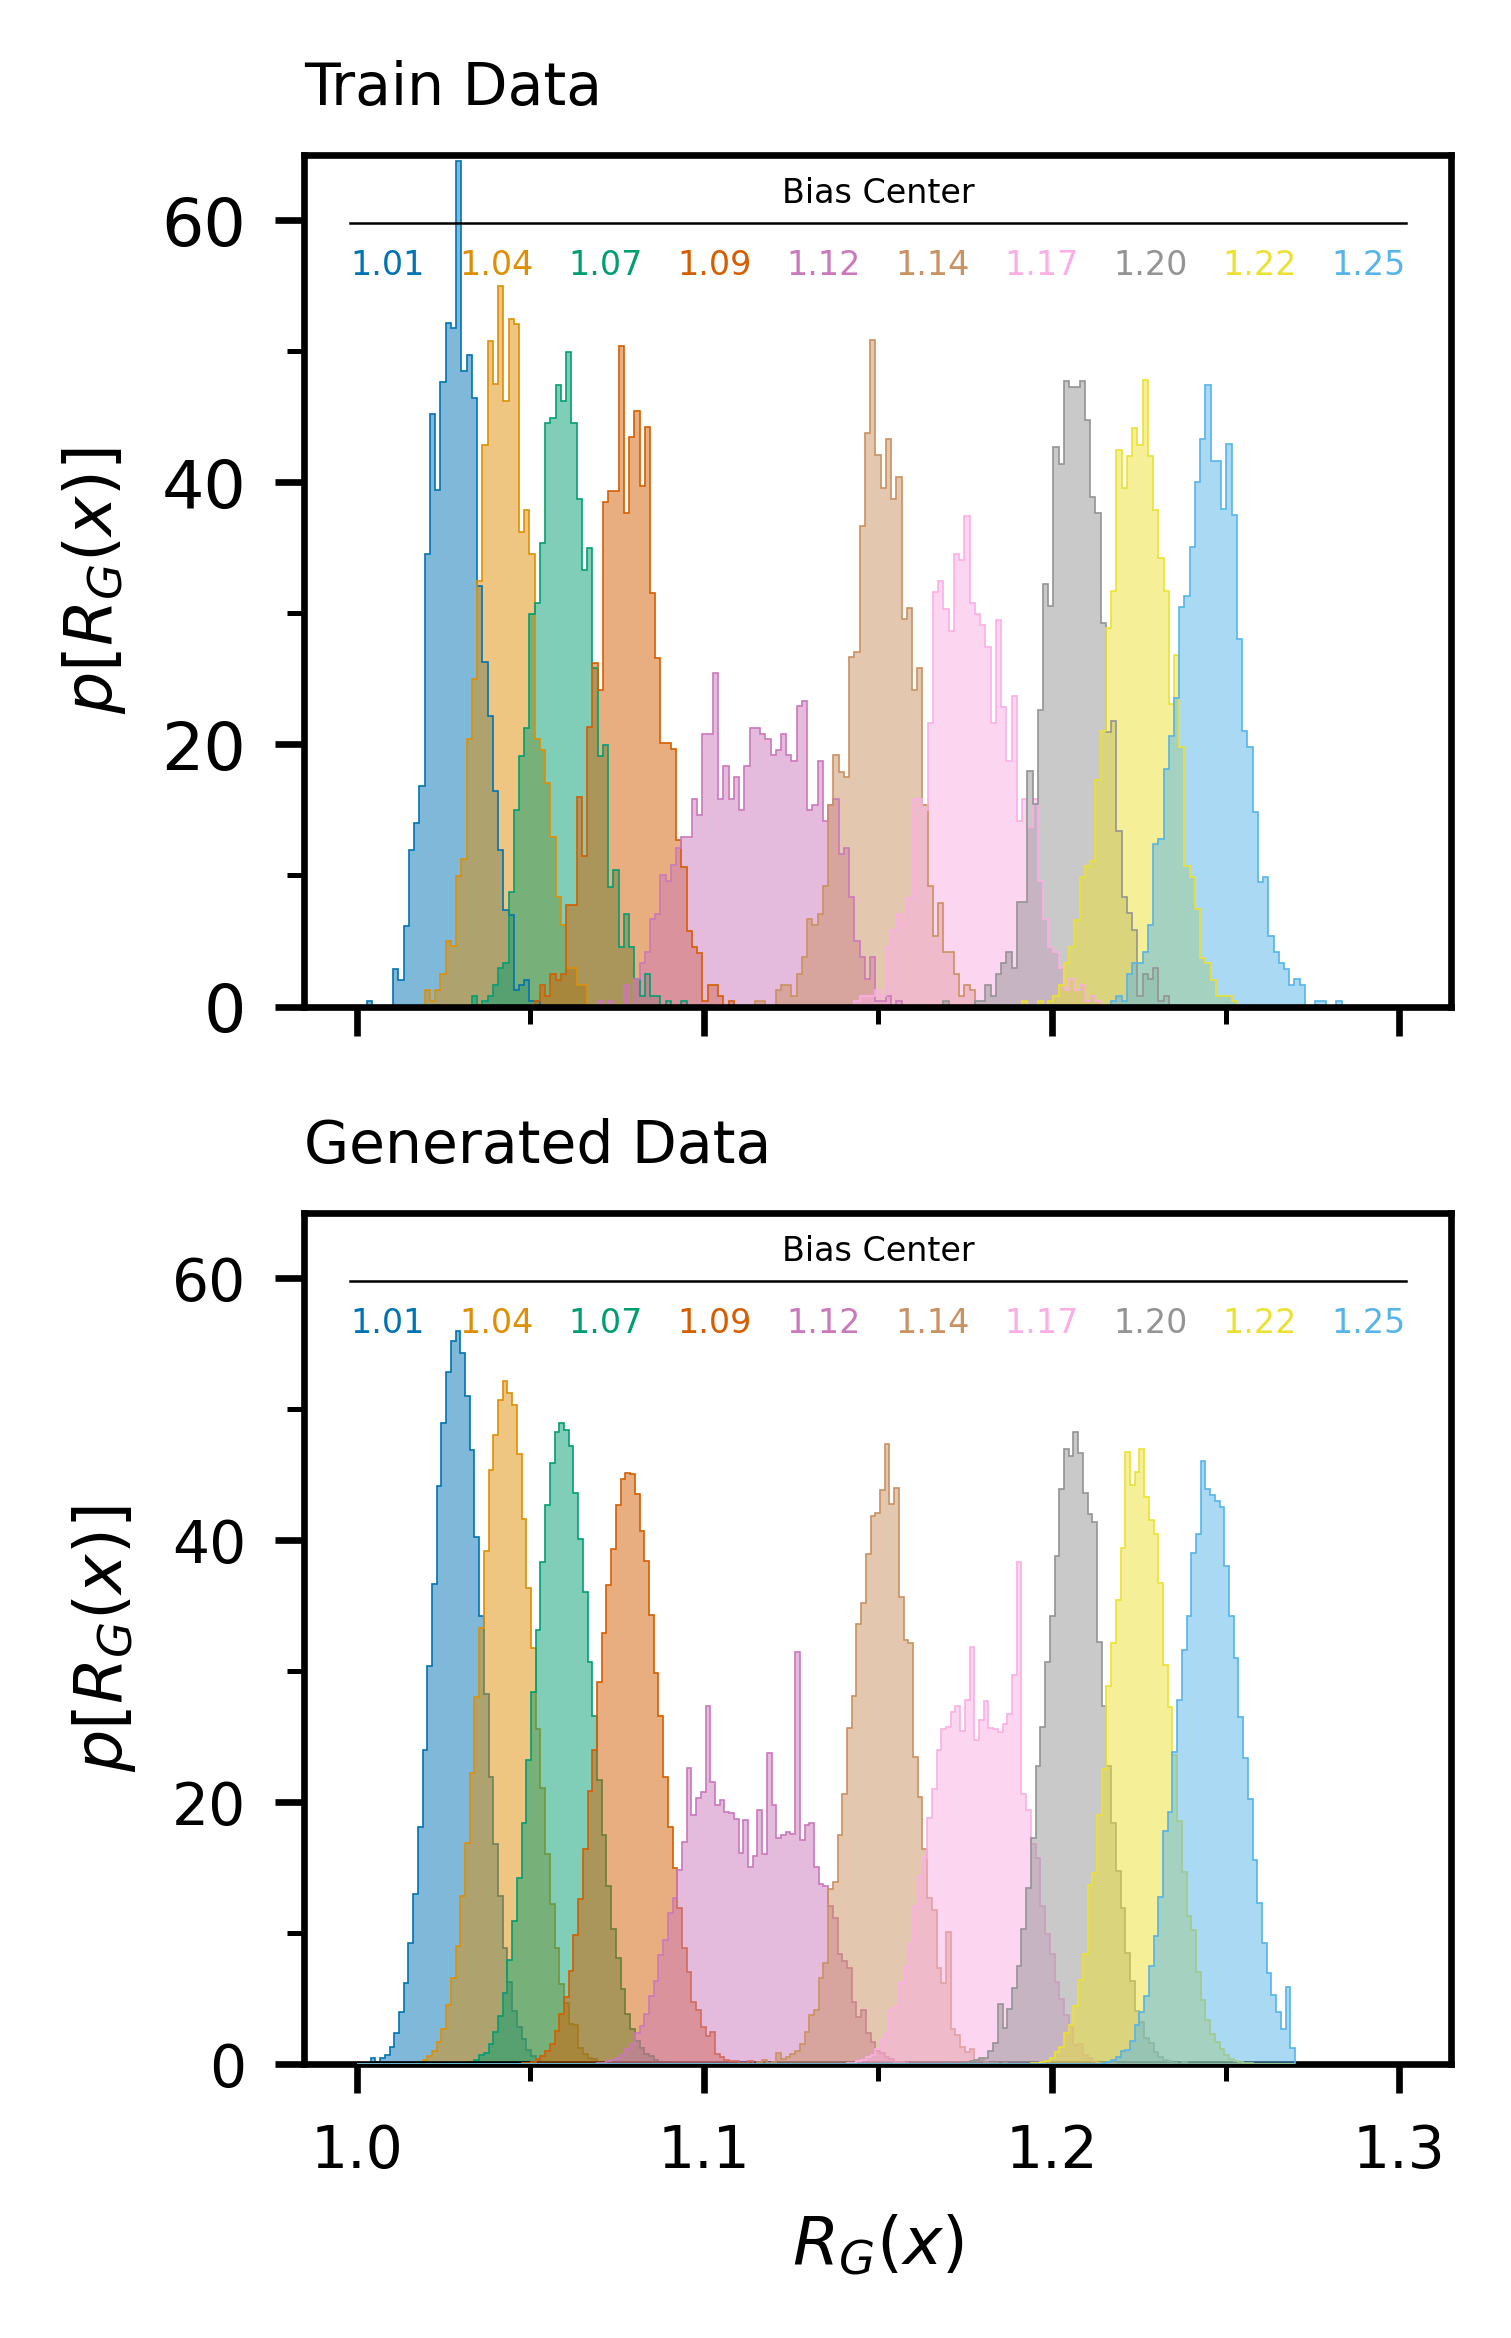

In [10]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
mpl.rcParams.update({'font.size': 8})

fig_size = (6.5 * 0.393701, 10 * 0.393701)

fig, ax = plt.subplots(2, 1, figsize = fig_size, dpi = 600, sharex=True, sharey=True)



legend_y = 0.87

for i, ref_c in enumerate(torch.unique(train_dataset.train_c_xz)):
    
    x = train_dataset.train_data_xz[torch.where(train_dataset.train_c_xz == ref_c)[0]]
    
    condition = generator.condition_function(x).cpu().numpy().ravel()

    ax[0].hist(condition, density=True, bins=np.linspace(1, 1.3, 200), histtype="step", lw=0.2, color="C{}".format(i))
    ax[0].hist(condition, density=True, bins=np.linspace(1, 1.3, 200), histtype="stepfilled", lw=0, alpha=0.5, color="C{}".format(i))
    
    
    ax[0].text(0.04 + 0.095 * i, legend_y,"{:.2f}".format(ref_c),
               horizontalalignment='left',
               verticalalignment='center',
               fontsize= 4,
               color="C{}".format(i),
               transform = ax[0].transAxes)


ax[0].text(0.5, legend_y+0.085,"Bias Center",
           horizontalalignment='center',
           verticalalignment='center',
           fontsize= 4,
           transform = ax[0].transAxes)

ax[0].plot([0.04,1-0.04], [legend_y + 0.05, legend_y + 0.05], transform = ax[0].transAxes, lw=0.3, c="0")


ax[0].set_title("Train Data", fontsize= 7, loc="left")


N = 1000000

legend_y = 0.87

#for i, ref_c in enumerate(np.linspace(1, 1.25, 20)[1::2]):
for i, ref_c in enumerate(torch.unique(train_dataset.train_c_xz)):
    
    with torch.no_grad():

        z, sample_coord, log_w= generator.sample(N, 0.1, resample=False, ref_condition= torch.ones(N, 1).cuda(0) * ref_c, batch_size=None)

        generated_condition = generator.condition_function(sample_coord).cpu().numpy().ravel()

    w_gen = np.exp( (log_w-log_w.max()).squeeze().cpu().numpy() )
    
    ax[1].hist(generated_condition, weights=w_gen, density=True, bins=np.linspace(1, 1.27, 200), histtype="step", lw=0.2, color="C{}".format(i), zorder=i)
    ax[1].hist(generated_condition, weights=w_gen, density=True, bins=np.linspace(1, 1.27, 200), histtype="stepfilled", lw=0, alpha=0.5, color="C{}".format(i), zorder=i)
    
    
    ax[1].text(0.04 + 0.095 * i, legend_y,"{:.2f}".format(ref_c),
               horizontalalignment='left',
               verticalalignment='center',
               fontsize= 4,
               color="C{}".format(i),
               transform = ax[1].transAxes)


ax[1].text(0.5, legend_y+0.085,"Bias Center",
           horizontalalignment='center',
           verticalalignment='center',
           fontsize= 4,
           transform = ax[1].transAxes)

ax[1].plot([0.04,1-0.04], [legend_y + 0.05, legend_y + 0.05], transform = ax[1].transAxes, lw=0.3, c="0")

ax[0].set_ylim(0, 65)
ax[1].set_ylim(0, 65)
ax[1].set_title("Generated Data", fontsize= 7, loc="left")

ax[0].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax[0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax[1].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax[1].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

ax[1].tick_params(axis='both', which='both', labelsize=7) 

ax[1].set_xlabel("$R_G(x)$")
ax[0].set_ylabel("$p[R_G(x)]$")
ax[1].set_ylabel("$p[R_G(x)]$")
plt.tight_layout()

## TPS

### Sampling

In [11]:

N_paths = 1000
N_SP = 50000 # Sample some more points to get a consistent reweighting result
path_model = inertial_langevin_integrator(system, length=500000,dt=5e-3,gamma=4, m=1, T=.1)

In [12]:

@jit(nopython=True)
def check_state(x):
    
    params = [7,  2, 1, 1]
    U_total = 0
    conf = x.reshape(int(params[0]), int(params[1]))

    for i in range(params[0]):
        for j in range(i+1, params[0]):
            if i != j:
                r = np.linalg.norm(conf[j]-conf[i])

                term1 = np.power(params[3]/r, 6)
                term2 = np.square(term1)
                U_part = 4 * params[2] * (term2 - term1 )
                U_total +=  U_part
                
    x = np.reshape(x, (7,2))
    
    r = np.sqrt(np.square(x[:,0]) +  np.square(x[:,1]))
    
    sq_r = np.square(r) 
    
    msd = sq_r.sum()/sq_r.shape[0]
    msd = np.sqrt(msd)
    
    if U_total <  -11.2 and msd > 1.2:
        return -1
    elif U_total <  -12.3  and msd < 1.05:
        return 1
    else:
        return 10


def add_symmetry(z):

    z_p = z.reshape((z.shape[0], -1, 2))

    x_p = z_p.clone()

    mirror_indices = np.random.choice(np.arange(z.shape[0]), replace=False, size=z.shape[0]//2)

    x_p[mirror_indices, :, 0] = -x_p[mirror_indices, :, 0]

    x = x_p.reshape((z.shape[0], -1))

    return x

In [13]:

def sample_path(shooting_points, sp_index, path_model, check_state, path_stride):
    
    shooting_point = shooting_points[sp_index]

    v = np.random.normal(loc=0, scale=np.sqrt(path_model.T), size=system.dofs)

    path_fw, _ = path_model.generate_flexible_path(shooting_point, v, check_state, 150000, 25, remove_com_motion=True)
    path_rv, _ = path_model.generate_flexible_path(shooting_point, -v, check_state, 150000, 25, remove_com_motion=True)
    
    trial_path = np.vstack([path_rv[::-1], path_fw[1:]])
        
    return trial_path

In [14]:
*_, shooting_points, _ = generator.sample(N_SP, T=T_ref, ref_condition=torch.ones(N_SP, 1).to(device) * 1.125, resample=True)
shooting_points = shooting_points.cpu().numpy()

In [15]:

transition_paths = []

for i in range(N_paths):
    print(i, end="\r")
    transition_paths.append(sample_path(shooting_points, i, path_model, check_state, 1))

### Reweighting

In [16]:
log_path_weights = []
    
for trial_path in transition_paths:
    
    forward_state = check_state(trial_path[-1])
    reverse_state = check_state(trial_path[0])

    if forward_state + reverse_state != 0:
        log_w = -np.inf
        
    else:
        
        torch_trial_path = torch.from_numpy(trial_path.copy()).to(generator.device)
        
        log_w = generator.log_path_weight(torch_trial_path, 1.125, T_ref, generated_distribution=False).item()

    log_path_weights.append(log_w)

In [17]:
weights = np.exp(log_path_weights - np.max(log_path_weights))


Text(0, 0.5, '$p(\\tau$)')

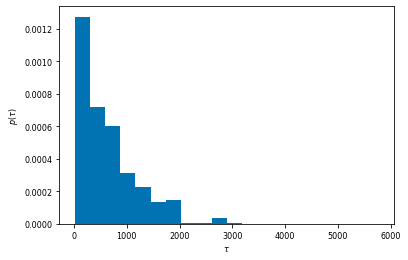

In [18]:
path_lengths_unweighted = [len(TP) for TP in transition_paths]

plt.hist(path_lengths_unweighted, weights=weights, bins=20, density=True)
plt.xlabel("$\\tau$")
plt.ylabel("$p(\\tau$)")